In [14]:
import cv2 
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
import os
import json

In [15]:
path_jsons = "/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/Thesis/Custom_deep_learning_models/semantic_segmentation_v3/dataset_labelme"
path_images = "/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK"

In [16]:
def plot_image(img, figsize_in_inches=(10,10)):
    fig, ax = plt.subplots(figsize=figsize_in_inches)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
def plot_images(imgs, figsize_in_inches=(10,10)):
    fig, axs = plt.subplots(1, len(imgs), figsize=figsize_in_inches)
    for col, img in enumerate(imgs):
        axs[col].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [17]:
def get_binary_mask(jsonfile_path, img_path) :
    # Read the JSON file
    with open(jsonfile_path, 'r') as file:
        json_data = json.load(file)

    # Load the image
    image = cv2.imread(img_path)

    # Create an empty mask
    mask = np.zeros_like(image[:, :, 0])

    # Iterate through the polygons
    polygons = json_data['shapes']
    if polygons is not None: 
        for polygon in polygons:
            points = polygon['points']
            points = np.array(points, dtype=np.int32)

            # Draw the polygon on the mask
            cv2.fillPoly(mask, [points], 255)
        return mask
    else:
        return None

In [18]:
masks = []
for file in os.listdir(path_jsons) : 
    if file.endswith(".json") : 
        img_path = os.path.join(path_images, file.replace(".json", ".jpg"))
        if os.path.isfile(img_path) : 
            print(img_path)
            mask = get_binary_mask(os.path.join(path_jsons, file), img_path)
            if mask is not None :
                masks.append({file.replace(".json", ""): mask})

print(masks)

/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame19775.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame22425.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame650.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame2250.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame21950.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK/2020_KBK_frame6950.jpg
/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Indus

In [48]:
def get_skeleton(mask_gray, mask_rgb, contour) : 
    print("Getting the skeleton and the pruned skeleton")

    rows, cols = mask_gray.shape[:2]

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # 1. Skeletonize
    skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)*255
    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    skeleton_bgr_copy = skeleton_bgr.copy()

    # 2. Pruning (remove small branches)
    # harris corner detection
    dst = cv2.cornerHarris(skeleton_gray, 2, 7, 0.09)
    max_dst = dst.max()
    harris_points = []

    # get harris points: threshold for an optimal value, it may vary depending on the image, now go over each element of dst 
    # and see if it is greater than threshold
    for i in range(dst.shape[0]):
        for j in range(dst.shape[1]):
            if dst[i,j] > 0.02*max_dst:
                harris_points.append((j,i))
                # set the harris points to a black pixel
                cv2.circle(skeleton_bgr_copy, (j,i), 2, (0, 0, 0), 3)
                # cv2.circle(skeleton_bgr, point, 2, (0, 0, 255), 3)
                # skeleton_bgr[i,j] = (0, 0, 0)


    # find contours of the skeleton with the intersections (harris points) removed
    skeleton_pruning_gray = cv2.cvtColor(skeleton_bgr_copy, cv2.COLOR_BGR2GRAY)
    # create a mask with the same size as skeleton_bgr, to draw only the contours that are big enough
    skeleton_pruning_bgr = np.zeros_like(skeleton_bgr_copy)
    # find the contours and draw only the big ones
    contours_branches, hierarchy = cv2.findContours(skeleton_pruning_gray, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    for contour_branch in contours_branches : 
        if cv2.arcLength(contour_branch, closed=False) > 300 : 
            # cv2.drawContours(skeleton_bgr, [contour_branch], contourIdx=-1, color=(0, 255, 0), thickness=1)
            cv2.drawContours(skeleton_pruning_bgr, [contour_branch], contourIdx=-1, color=(255, 255, 255), thickness=1)
            # plot_image(skeleton_pruning_bgr)

            # vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            # lefty = int((-x*vy/vx) + y)
            # righty = int(((cols-x)*vy/vx)+y)
            # cv2.line(skeleton_pruning_bgr,(cols-1,righty),(0,lefty),(0,255,0),2)
    
    for point in harris_points :
        # cv2.circle(skeleton_bgr, point, 2, (0, 0, 255), 3)
        skeleton_pruning_bgr[point[1], point[0]] = (255, 255, 255)
        # draw a circle of radius 2 and see if it intersects with the contour (a road)
        # skeleton_pruning_bgr[point[1], point[0]] = (255, 255, 255)
        # circle equation: (x - point[1])^2 + (y - point[0])^2 = radius^2
    
    return skeleton_bgr, skeleton_pruning_bgr

    

In [40]:
def neighbours(x, y, img):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    return [img[x-1][y], img[x-1][y-1], img[x][y-1], img[x+1][y-1], img[x+1][y], img[x+1][y+1], img[x][y+1], img[x-1][y+1]]   


def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                if neighbours(x, y, image) in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


# def custom_find_intersections(skeleton) :
#     skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY) 
#     skeleton_gray_normalized = skeleton_gray / 255
#     # go over each white pixel of skeleton 
#     # and check if it has more than 2 white neighbors
#     intersections = []
#     for i in range(1, skeleton_gray.shape[0]-1) :
#         for j in range(1, skeleton_gray.shape[1]-1) :
#             if skeleton_gray[i,j] == 255 :
#                 # check if it has more than 2 white neighbors
#                 # kernel for 8 neighbors:
#                 # 1 1 1
#                 # 1 1 1
#                 # 1 1 1
#                 kernel = np.array([[1,1,1],[1,1,1],[1,1,1]])
#                 neighbors = cv2.convolve(skeleton_gray_normalized[i-1:i+2,j-1:j+2], kernel, cv2.CV_32F)
#                 if np.sum(neighbors) > 2 :
#                     intersections.append((i,j))
#                     cv2.circle(skeleton, (j,i), 1, (0,0,255), 4)
    
#     print("Custom find intersections")
#     plot_image(skeleton)
                

In [35]:
def find_polygon(mask_gray, mask_bgr, contour, skeleton_contour) : 
    """Find the polygon of the contour in the mask_rgb"""
    
    # create a mask with the contour
    rows, cols = mask_gray.shape[:2]
    contour_mask = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask, [contour], -1, 255, -1)

    # convex hull (scikit-image)
    hull = convex_hull_image(contour_mask)
    hull = hull.astype(np.uint8) * 255
    plt.imshow(hull, cmap='gray')
    plt.show()

    skeleton_contour_gray = cv2.cvtColor(skeleton_contour, cv2.COLOR_BGR2GRAY)
    white_pixels = np.where(skeleton_contour_gray == 255)
    # print(f"white_pixels = {white_pixels}")
    x_values = white_pixels[1]
    y_values = white_pixels[0]
    # print(f"Lenght of x_values = {len(x_values)}")
    # coeffs = Polynomial.fit(x=x_values, y=y_values, deg=2)
    coeffs = np.polyfit(x_values, y_values, deg=2)
    print(f"Coeffs = {coeffs}")
    # evaluate coefficients for all values of x
    for x in range(cols) : 
        y = np.polyval(coeffs, x)
        if y >= 0 and y < rows :
            mask_bgr[int(y), x] = (0, 0, 255)
            skeleton_contour[int(y), x] = (0, 0, 255)

    plot_image(mask_bgr)
    plot_image(skeleton_contour)

    # poly = np.poly1d(coeffs)



    # print(f"Lenght of poly = {len(poly)}")
    # y_fit = np.polyval(poly, x_values)
    # xx, yy = coeffs.linspace()
    # print(f"Xx = {xx}")
    # print(f"Yy = {yy}")
    # print(f"y_fit = {y_fit}")
    # print(f"Lenght of y_fit = {len(y_fit)}")
    
    #for i in range(len(xx)) :
        # print(f"({xx[i]}, {yy[i]})")
        # print(f"({int(xx[i])}, {int(yy[i])})")
        # cv2.circle(mask_rgb, (int(xx[i]), int(yy[i])), 2, (0, 0, 255), 3)

    # fit line on contour
    # max x value in contour and max y value in contour
    # max_x = np.max(contour[:, 0, 0])
    # max_y = np.max(contour[:, 0, 1])
    # vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
    # lefty = int((-x*vy/vx) + y)
    # righty = int(((cols-x)*vy/vx)+y)
    # cv2.line(mask_rgb,(cols-1,righty),(0,lefty),(0,255,0),2)

    # plot_image(mask_rgb)

In [29]:
def find_intersection(mask_gray, mask_bgr, contour, skeleton_contour) : 
    rows, cols = mask_gray.shape[:2]
    contour_mask_gray = np.zeros_like(mask_gray)
    # from rgb to gray for drawing
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)

    # skeletonize
    skeleton_gray = skeletonize(contour_mask_gray)
    skeleton_gray = skeleton_gray.astype(np.uint8) * 255
    _, skeleton_gray = cv2.threshold(skeleton_gray , 127, 255, cv2.THRESH_BINARY)
    # print(f"Skeleton = {skeleton}")
    # print(f"Skeleton > 0 = {skeleton > 0}")
    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    skeleton_bgr_copy = skeleton_bgr.copy()

    # pruning = remove_small_objects(skeleton < 255, min_size=30)
    # pruning = pruning.astype(np.uint8) * 255
    # pruning_rgb = cv2.cvtColor(pruning, cv2.COLOR_GRAY2RGB)

    # medial axis
    # medial = medial_axis(contour_mask_gray)
    # medial = medial.astype(np.uint8) * 255
    # medial_rgb = cv2.cvtColor(medial, cv2.COLOR_GRAY2RGB)

    # thinning
    # thinned = thin(contour_mask_gray, max_num_iter=50)
    # thinned = thinned.astype(np.uint8) * 255
    # thinned_rgb = cv2.cvtColor(thinned, cv2.COLOR_GRAY2RGB)

    # harris corner detection
    dst = cv2.cornerHarris(skeleton_gray, 2, 7, 0.09)
    max_dst = dst.max()
    harris_points = []

    # max_i, max_j = np.unravel_index(dst.argmax(), dst.shape)
    # cv2.circle(contour_mask_rgb, (max_j,max_i), 3, (0, 0, 255), -1)
    # cv2.circle(skeleton_rgb, (max_j,max_i), 3, (0, 0, 255), -1)

    # Threshold for an optimal value, it may vary depending on the image
    # Now go over each element of dst and see if it is greater than threshold
    for i in range(dst.shape[0]):
        for j in range(dst.shape[1]):
            if dst[i,j] > 0.02*max_dst:
                harris_points.append((j,i))
                cv2.circle(contour_mask_bgr, center=(j,i), radius=1, color=(0, 0, 255), thickness=1)
                skeleton_bgr_copy[i,j] = (0, 0, 0)
                # cv2.circle(skeleton_bgr_copy, center=(j,i), radius=1, color=(0, 0, 0), thickness=1)


    plot_image(contour_mask_bgr)
    plot_image(skeleton_bgr_copy)

    # Pruning the skeleton, remove the small branches
    # first find contours 
    skeleton_pruning_gray = cv2.cvtColor(skeleton_bgr_copy, cv2.COLOR_BGR2GRAY)
    # create a mask with the same size as skeleton_bgr
    skeleton_pruning_bgr = np.zeros_like(skeleton_bgr)
    contours, hierarchy = cv2.findContours(skeleton_pruning_gray, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours : 
        if cv2.arcLength(contour, closed=False) > 250 : 
            cv2.drawContours(skeleton_bgr, [contour], contourIdx=-1, color=(0, 255, 0), thickness=1)
            cv2.drawContours(skeleton_pruning_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)

            vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            lefty = int((-x*vy/vx) + y)
            righty = int(((cols-x)*vy/vx)+y)
            cv2.line(skeleton_pruning_bgr,(cols-1,righty),(0,lefty),(0,255,0),2)
    
    for point in harris_points :
        # draw a circle of radius 2 and see if it intersects with the contour (a road)
        cv2.circle(skeleton_bgr, center=point, radius=2, color=(0, 0, 255), thickness=1)
        # cv2.circle(skeleton_pruning_bgr, center=point, radius=1, color=(255, 255, 255), thickness=1)
        # cv2.line(skeleton_pruning_bgr, pt1=(j, i), pt2=(j, i), color=(255, 255, 255), thickness=1)
        skeleton_pruning_bgr[point[1], point[0]] = (255, 255, 255)
        # circle equation: (x - point[1])^2 + (y - point[0])^2 = radius^2

    print("Skeleton after pruning...")
    plot_image(skeleton_bgr)
    plot_image(skeleton_pruning_bgr)

    
    
    # plot_image(pruning_rgb)
    # plot_image(medial_rgb)
    # plot_image(thinned_rgb)

In [72]:
def post_process(mask) : 
    # mask = binary_closing(mask)
    # mask = mask.astype(np.uint8) * 255

    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    mask_gray_copy = mask.copy()
    mask_bgr_copy = mask_bgr.copy()
    height, width = mask_bgr.shape[:2]

    # SKIP canny edge detection
    # mask_canny = cv2.Canny(eroded_mask, 100, 170, apertureSize=3)
    # plt.imshow(mask_canny, cmap='gray')
    # plt.show()

    # boolean to check if there is an intersection in the image, if there is one, we try to match only the intersection
    intersection_in_image = False

    # find contours and draw them
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(mask_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    # filter out the contours with a small area
    # print(f"Total area: {height * width}")
    # thresh_area = 0.01 * height * width
    # thresh_length = 0.5 * (1/2 * (height+width))
    # contours = [contour for contour in contours if cv2.arcLength(contour, closed=True) > thresh_length]
    # print(f"Number of contours after filtering out the ones with small area: {len(contours)}")

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour (and prune it)
            skeleton_contour_bgr, skeleton_contour_pruning_bgr = get_skeleton(mask_gray_copy, mask_bgr_copy, contour)

            # skeleton of the whole image -> bitwise OR operation
            # skeleton_image_bgr = cv2.bitwise_or(skeleton_image_bgr, skeleton_contour_gray)


            #  make a decision based on the solidity
            if solidity < 0.60 :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                # now find the possible intersection, if there is one
                intersections = get_skeleton_intersection(skeleton_contour_bgr)
                # visualization
                skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                for intersection in intersections :
                    print(f"Shape of skeleton_contour_bgr_copy: {skeleton_contour_bgr_copy.shape}")
                    print(f"Intersection: {intersection}")
                    print(f"Intersection[0]: {intersection[0]}")
                    print(f"Intersection[1]: {intersection[1]}")
                    skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    print(skeleton_contour_bgr_copy[intersection[1], intersection[0]])
                    # cv2.circle(skeleton_contour_bgr_copy, center=intersection, radius=2, color=(0, 0, 255), thickness=2)
                plot_image(skeleton_contour_bgr_copy)
                if intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")


    # if intersection_in_image : 
        # if boolean intersection_in_image is True, there is guaranteed to be an intersection in the image
    # else : 
        # however, even if intersection_in_image is False, it is still possible that the extension of some contours 
        # can correspond to an intersection

        
        
        
        
        
        
        # skeleton = skeletonize(image=mask_copy, method='zhang')
        # plt.imshow(skeleton, cmap=plt.cm.gray)
        # plt.show()


        # plot_image(mask_rgb_copy)

2020_KBK_frame19775


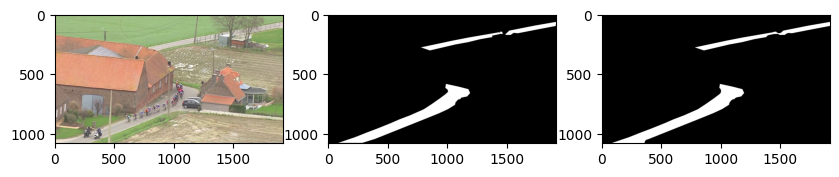

Number of contours: 2
Contour length: 2716.7505534887314
Contour area: 94101.5
Convex hull area: 163767.0
Getting the skeleton and the pruned skeleton
Solidity = 0.5746059951027985 -> this contour can be related to an intersection in the road
Getting intersections in skeleton (more than 2 neighbours)
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (1007, 607)
Intersection[0]: 1007
Intersection[1]: 607
[  0   0 255]
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (1054, 661)
Intersection[0]: 1054
Intersection[1]: 661
[  0   0 255]


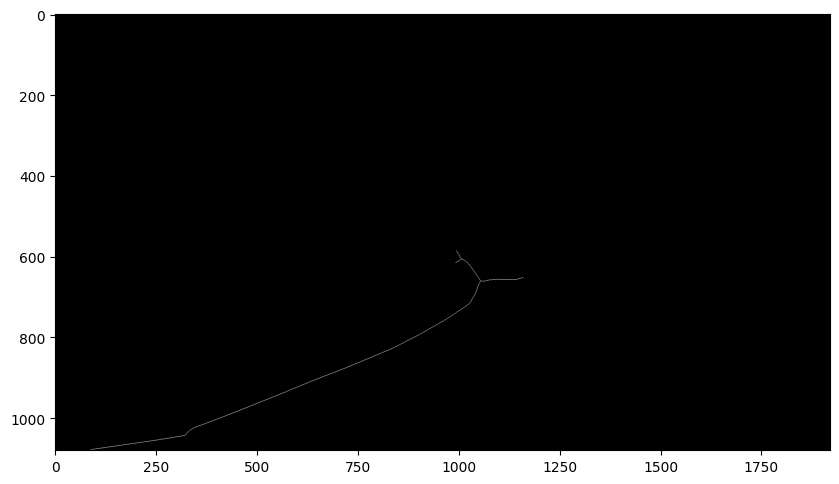

Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
Contour length: 2510.378847718239
Contour area: 36111.5
Convex hull area: 46170.5
Getting the skeleton and the pruned skeleton
Solidity = 0.7821336134544785 -> no intersection in this contour
2020_KBK_frame22425


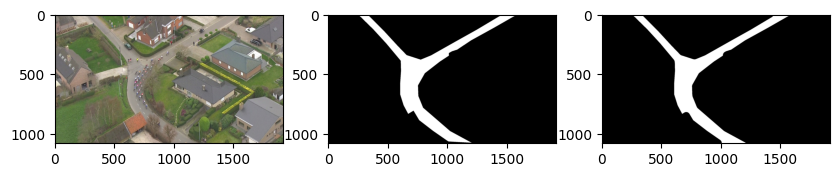

Number of contours: 1
Contour length: 5179.193670749664
Contour area: 201316.5
Convex hull area: 911467.0
Getting the skeleton and the pruned skeleton
Solidity = 0.2208708598336528 -> this contour can be related to an intersection in the road
Getting intersections in skeleton (more than 2 neighbours)
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (699, 464)
Intersection[0]: 699
Intersection[1]: 464
[  0   0 255]
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (718, 767)
Intersection[0]: 718
Intersection[1]: 767
[  0   0 255]


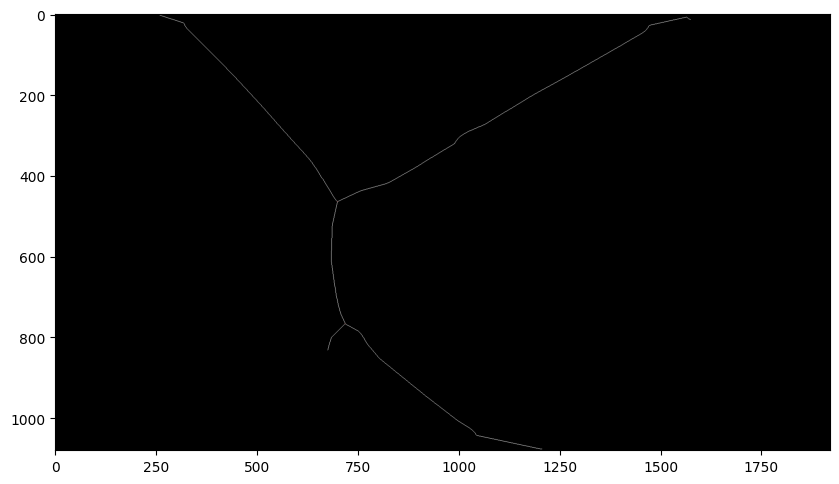

Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
2020_KBK_frame650


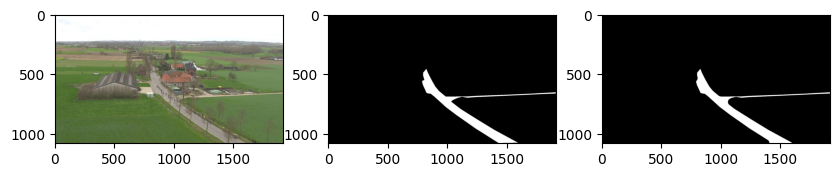

Number of contours: 1
Contour length: 4033.8359019756317
Contour area: 75541.0
Convex hull area: 386115.5
Getting the skeleton and the pruned skeleton
Solidity = 0.1956435315339581 -> this contour can be related to an intersection in the road
Getting intersections in skeleton (more than 2 neighbours)
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (1021, 729)
Intersection[0]: 1021
Intersection[1]: 729
[  0   0 255]
Shape of skeleton_contour_bgr_copy: (1080, 1920, 3)
Intersection: (1021, 730)
Intersection[0]: 1021
Intersection[1]: 730
[  0   0 255]


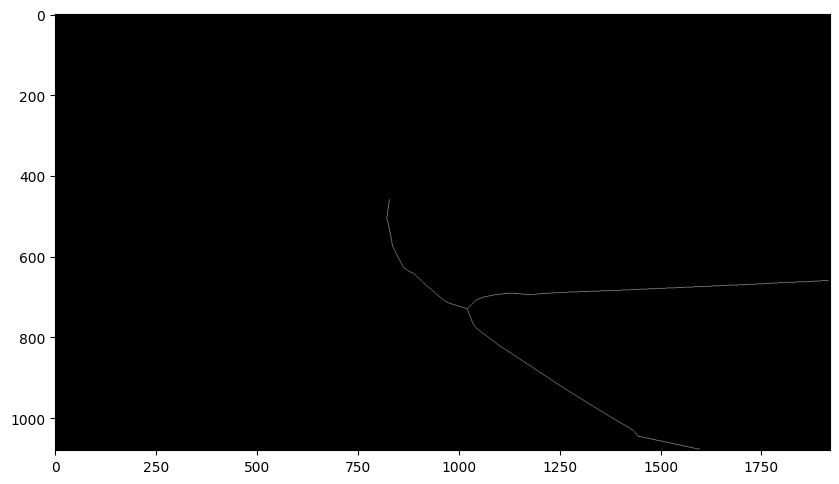

Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
2020_KBK_frame2250


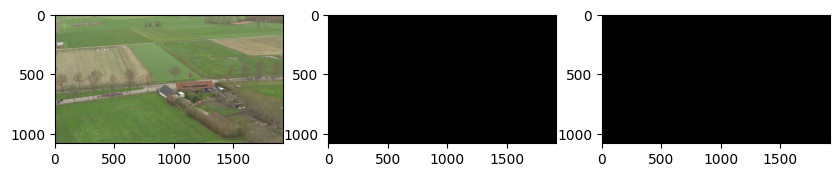

Number of contours: 0
2020_KBK_frame21950


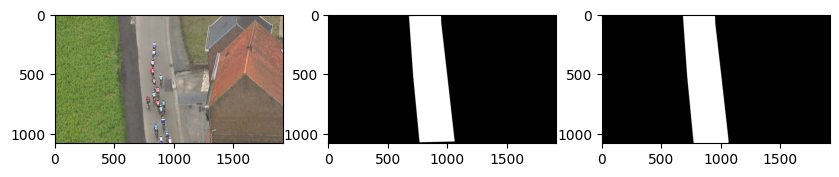

Number of contours: 1
Contour length: 2800.05591070652
Contour area: 306181.5
Convex hull area: 309621.5
Getting the skeleton and the pruned skeleton
Solidity = 0.9888896604402472 -> no intersection in this contour
2020_KBK_frame6950


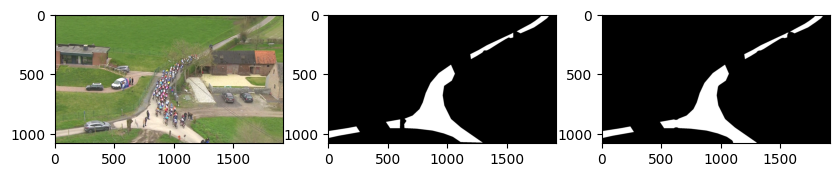

Number of contours: 6
Contour length: 659.7056245803833
Contour area: 13244.0
Convex hull area: 14017.5
Getting the skeleton and the pruned skeleton
Solidity = 0.9448189762796504 -> no intersection in this contour
Contour length: 2642.2063950300217
Contour area: 146949.5
Convex hull area: 280052.0
Getting the skeleton and the pruned skeleton


KeyboardInterrupt: 

In [73]:
vid_path = "/Users/senneloobuyck/Library/CloudStorage/OneDrive-UGent/Industrieel/UGent_2022-2023/VENTOUX_v1.0/01_inputs/frames-from-vid/2020_KBK"
# now for every mask, do postprocessing
for dictionary in masks:
    label = next(iter(dictionary))  
    print(label)
    mask = dictionary[label] 
    image = cv2.imread(os.path.join(vid_path, label)+".jpg")

    foot = square(50)
    
    # Dilation (scikit-image)
    # dilate = binary_dilation(mask, footprint=foot)
    # dilate = dilate.astype(np.uint8) * 255
    # plt.imshow(dilate, cmap='gray')
    # plt.show()

    # Closing (scikit-image)
    # closing = binary_closing(mask, footprint=foot)
    closing = isotropic_closing(mask, radius=30)
    closing = closing.astype(np.uint8) * 255

    # Convex hull (scikit-image)
    # hull = convex_hull_image(mask)
    # hull = hull.astype(np.uint8) * 255
    # plt.imshow(hull, cmap='gray')
    # plt.show()


    # Erosion (scikit-image)
    # mask = binary_erosion(mask, structuring_element=disk)
    # mask = mask.astype(np.uint8) * 255
    # plt.imshow(mask, cmap='gray')
    # plt.show()

    # Erosion (OpenCV)
    # kernel = np.ones((11, 11), np.uint8)  # You can adjust the size of the kernel
    # mask = cv2.erode(mask, kernel, iterations=3)


    plot_images([image, mask, closing])
    post_process(closing)
